## Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

### Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Submission File Format
The file should contain a header and have the following format:

    Id,SalePrice
    1461,169000.1
    1462,187724.1233
    1463,175221
    etc.

In [538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [539]:
train = pd.read_csv("housing_train.csv")
#df = pd.read_csv("housing_test.csv")
test =  pd.read_csv("housing_test.csv")


In [540]:
# Train has Ids less than 1461. 

In [541]:
diff = [col for col in df.columns if col not in test.columns ]

In [542]:
df = pd.concat([train,test])

In [543]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [544]:
df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


With 81 features, it is important to get a good idea of the distribution and shape of each without getting too much into the weeds. Luckily, we have the data dictionary which can give me an idea of which features are discrete, continous, etc.

All features with less than 65% complete data will be dropped, like PoolQC, Fence, MiscFeature, etc. Many features though are complete, so hopefully there is enough information in the multitude of high-quality features. 

Some features, like FireplaceQu, are more than half complete and include a value for no fireplaces, so it may be feasible to fill in the missing values with that value, if the other feature ("Fireplaces") is NaN.

## Plan

1) Pre-Processing
    - Drop mostly incomplete columns
    - Fill in empty columns using sister features (FireplaceQu & Fireplaces)

2) EDA
    - Is additional preprocessing necessary?
    - Standout relationships

3) Feature Transformation
    - dummy variables
    - create new vars with rooms etc
    - scaling continous

4) Feature Selection
    - Select KBest
    - Lasso

5) Fitting and Evaluation
    - Linear Regression
    - Random Forest

## Pre-Processing

In [545]:
#BsmtQual         1423 non-null object
#BsmtCond         1423 non-null object
#BsmtExposure     1422 non-null object
#BsmtFinType1     1423 non-null object
#BsmtFinType2     1422 non-null object
bsmt = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu']

for bs in bsmt:   
    df[bs] = df[bs].fillna('None')
    test[bs] = test[bs].fillna('None')


In [546]:
df['LotFrontage'].describe()

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

The plan here is to fill the missing 259 values with the median, 69.

In [547]:
df['LotFrontage'] = df['LotFrontage'].fillna(69)
test['LotFrontage'] = test['LotFrontage'].fillna(69)

In [548]:
df['GarageType'].value_counts()

Attchd     1723
Detchd      779
BuiltIn     186
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64

Looking at the data dictionary, NA values are no garages.

In [549]:
#GarageYrBlt      1379 non-null float64
#GarageFinish     1379 non-null object
#GarageCars       1460 non-null int64
#GarageArea       1460 non-null int64
#GarageQual       1379 non-null object
#GarageCond       1379 n
#GarageType

garage = ['GarageFinish','GarageQual','GarageCond','GarageType']

for g in garage:
    df[g] = df[g].fillna('None')
    test[g] = test[g].fillna('None')

(array([1.570e+02, 0.000e+00, 7.760e+02, 0.000e+00, 1.594e+03, 0.000e+00,
        3.740e+02, 0.000e+00, 1.600e+01, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

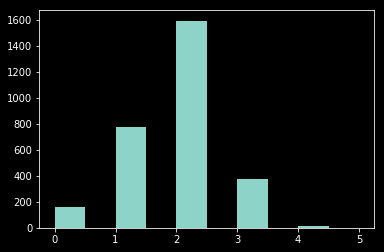

In [550]:
plt.style.use('dark_background')
plt.hist(df['GarageCars'].dropna())

Now most of the values that are greater than 50% full are clean. Let's create a new dataframe without the empty features:

In [551]:
cols = df.columns
new_cols = [e for e in cols if e not in ['Alley','PoolQC','Fence','MiscFeature']]

In [552]:
clean_df = df[new_cols]
new_cols.remove('SalePrice')
clean_test = test[new_cols]

## EDA

In [553]:
df['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

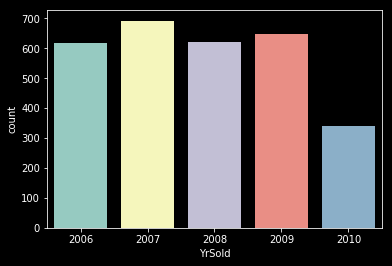

In [554]:
plt.style.use('dark_background')
sns.countplot(df['YrSold'])

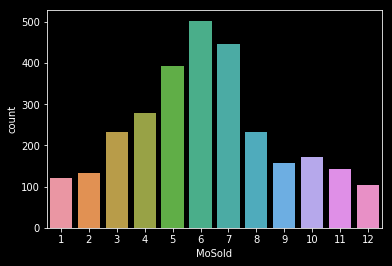

In [555]:
sns.countplot(df['MoSold'])

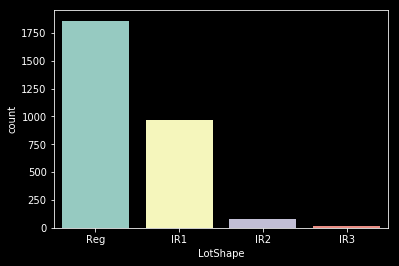

In [556]:
sns.countplot(df['LotShape'])

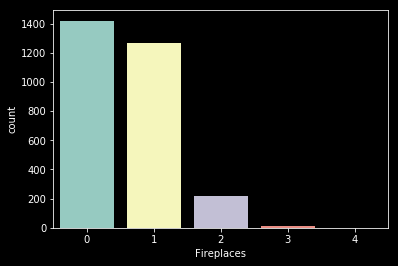

In [557]:
sns.countplot(df['Fireplaces'])

In [558]:
df[df['Fireplaces']==0]['FireplaceQu'].value_counts()

None    1420
Name: FireplaceQu, dtype: int64

(array([100.,   4.,  13.,  54.,  47.,  75., 227., 406., 945., 504., 268.,
        145.,  77.,  32.,  11.,   7.,   2.,   0.,   0.,   2.]),
 array([1.32221929, 1.38088555, 1.4395518 , 1.49821805, 1.5568843 ,
        1.61555056, 1.67421681, 1.73288306, 1.79154931, 1.85021556,
        1.90888182, 1.96754807, 2.02621432, 2.08488057, 2.14354682,
        2.20221308, 2.26087933, 2.31954558, 2.37821183, 2.43687809,
        2.49554434]),
 <a list of 20 Patch objects>)

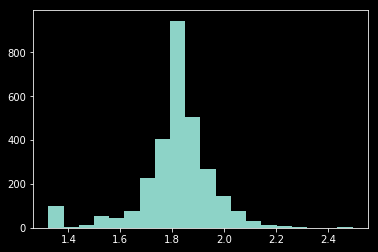

In [559]:
plt.hist(np.log10(df['LotFrontage'].dropna()),bins=20)#.plot(kind='hist')
#plt.xlim(0,350)

In [560]:
df[df['LotFrontage'] > 200]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
934,2069,0,0,NaN,4,1Fam,TA,Gd,425.0,0.0,...,WD,0,Pave,9,585.0,AllPub,0,1960,2007,2008
1298,4692,950,0,NaN,3,1Fam,TA,Gd,5644.0,0.0,...,New,0,Pave,12,6110.0,AllPub,214,2008,2008,2008


In [561]:
df['LotFrontage'].min()

21.0

(array([  7.,  15.,  53.,  73., 153., 227., 188., 155., 141.,  88.,  78.,
         66.,  44.,  42.,  20.,  29.,  20.,   8.,  10.,  13.,   7.,   5.,
          4.,   3.,   1.,   2.,   0.,   1.,   2.,   0.,   1.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 34900. ,  52902.5,  70905. ,  88907.5, 106910. , 124912.5,
        142915. , 160917.5, 178920. , 196922.5, 214925. , 232927.5,
        250930. , 268932.5, 286935. , 304937.5, 322940. , 340942.5,
        358945. , 376947.5, 394950. , 412952.5, 430955. , 448957.5,
        466960. , 484962.5, 502965. , 520967.5, 538970. , 556972.5,
        574975. , 592977.5, 610980. , 628982.5, 646985. , 664987.5,
        682990. , 700992.5, 718995. , 736997.5, 755000. ]),
 <a list of 40 Patch objects>)

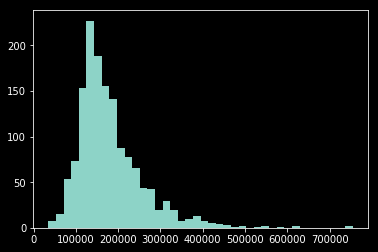

In [562]:
plt.hist(df['SalePrice'].dropna(),bins=40)

In [564]:
df[df['SalePrice'] > 500000]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
178,2234,0,0,NaN,1,1Fam,TA,No,1904.0,0.0,...,New,0,Pave,9,2216.0,AllPub,0,2008,2009,2009
440,2402,0,0,NaN,2,1Fam,TA,Gd,1767.0,539.0,...,WD,170,Pave,10,3094.0,AllPub,0,2008,2008,2009
691,2444,1872,0,NaN,4,1Fam,TA,Gd,1455.0,0.0,...,WD,0,Pave,10,2444.0,AllPub,382,1994,1995,2007
769,1690,1589,0,NaN,4,1Fam,TA,Gd,1416.0,0.0,...,WD,210,Pave,12,1650.0,AllPub,503,2003,2003,2010
803,1734,1088,0,NaN,4,1Fam,TA,Gd,0.0,0.0,...,New,192,Pave,12,1734.0,AllPub,52,2008,2009,2009
898,2364,0,0,NaN,2,1Fam,TA,Gd,2188.0,0.0,...,New,0,Pave,11,2330.0,AllPub,0,2009,2010,2010
1046,1992,876,0,NaN,4,1Fam,TA,Av,240.0,0.0,...,New,0,Pave,11,1992.0,AllPub,214,2005,2006,2006
1169,1831,1796,0,NaN,4,1Fam,TA,Gd,1387.0,0.0,...,WD,0,Pave,10,1930.0,AllPub,361,1995,1996,2006
1182,2411,2065,0,NaN,4,1Fam,TA,Av,2096.0,0.0,...,WD,0,Pave,10,2396.0,AllPub,171,1996,1996,2007


(0, 50000)

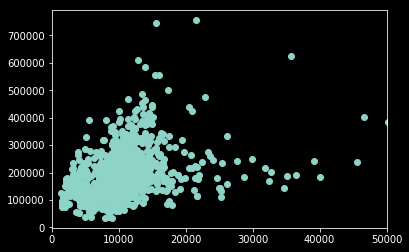

In [565]:
plt.scatter(df['LotArea'],df['SalePrice'])
plt.xlim(0,50000)

(0, 20000)

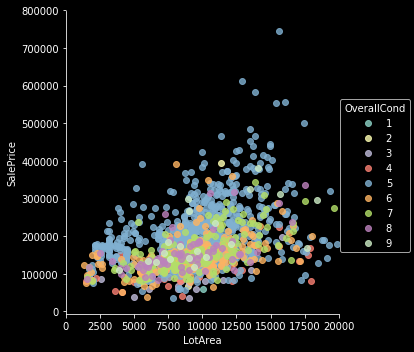

In [566]:
sns.lmplot('LotArea','SalePrice',hue='OverallCond',data=df,fit_reg=False)
plt.xlim(0,20000)

(array([2.151e+03, 4.450e+02, 1.650e+02, 7.200e+01, 3.700e+01, 1.000e+01,
        8.000e+00, 5.000e+00, 2.000e+00, 1.000e+00]),
 array([1.000e+00, 1.610e+02, 3.210e+02, 4.810e+02, 6.410e+02, 8.010e+02,
        9.610e+02, 1.121e+03, 1.281e+03, 1.441e+03, 1.601e+03]),
 <a list of 10 Patch objects>)

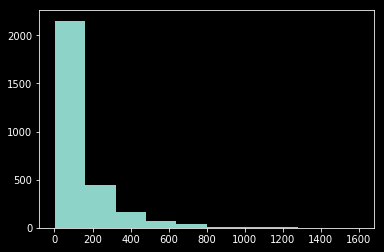

In [567]:
df['MasVnrArea'] = df['MasVnrArea']+1
plt.hist(df['MasVnrArea'].dropna())

In [568]:
df['MasVnrArea'].describe()

count    2896.000000
mean      103.201312
std       179.334253
min         1.000000
25%         1.000000
50%         1.000000
75%       165.000000
max      1601.000000
Name: MasVnrArea, dtype: float64

Most houses do not have Masonry Veneer areas, we can bin this feature so that if greater than 1, it has it, else it doesn't. We will also have to remove the other Masonry Veneer columns.

In [569]:
def has_feature(x):
    if x > 1:
        return 1
    else:
        return 0

(array([1.741e+03, 1.000e+00, 0.000e+00, 1.900e+01, 3.000e+01, 1.160e+02,
        3.040e+02, 4.510e+02, 2.020e+02, 3.200e+01]),
 array([0.        , 0.32043913, 0.64087827, 0.9613174 , 1.28175653,
        1.60219567, 1.9226348 , 2.24307393, 2.56351307, 2.8839522 ,
        3.20439133]),
 <a list of 10 Patch objects>)

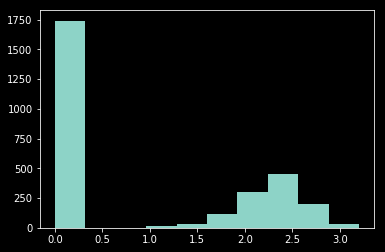

In [570]:
plt.hist(np.log10(df['MasVnrArea'].dropna()))

In [571]:
clean_df['MasVnr'] = clean_df['MasVnrArea'].apply(lambda x: has_feature(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [572]:
clean_df['MasVnr'].value_counts()

0    1764
1    1155
Name: MasVnr, dtype: int64

In [573]:
clean_df.drop(['MasVnrArea','MasVnrType'],inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([ 19.,  49.,  50.,  51., 108., 154., 385., 897., 746., 302.,  87.,
         34.,  12.,   8.,  11.,   2.,   0.,   1.,   2.,   1.]),
 array([3.11394335, 3.22489284, 3.33584232, 3.44679181, 3.5577413 ,
        3.66869078, 3.77964027, 3.89058975, 4.00153924, 4.11248873,
        4.22343821, 4.3343877 , 4.44533718, 4.55628667, 4.66723616,
        4.77818564, 4.88913513, 5.00008461, 5.1110341 , 5.22198359,
        5.33293307]),
 <a list of 20 Patch objects>)

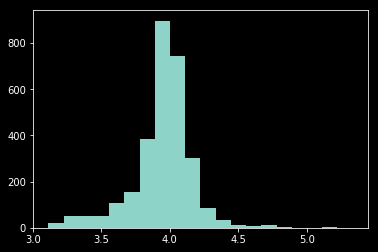

In [574]:
plt.hist(np.log10(df['LotArea'].dropna()),bins=20)#.plot(kind='hist')

In [575]:
needlog = []
needlog.append('LotArea')

In [576]:
needlog.append('LotFrontage')

In [577]:
clean_df['BsmtFinSF1'] = clean_df['BsmtFinSF1'] + 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([1.289e+03, 5.650e+02, 5.300e+02, 2.940e+02, 1.590e+02, 5.700e+01,
        1.400e+01, 6.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   0. ,  282.2,  564.4,  846.6, 1128.8, 1411. , 1693.2, 1975.4,
        2257.6, 2539.8, 2822. , 3104.2, 3386.4, 3668.6, 3950.8, 4233. ,
        4515.2, 4797.4, 5079.6, 5361.8, 5644. ]),
 <a list of 20 Patch objects>)

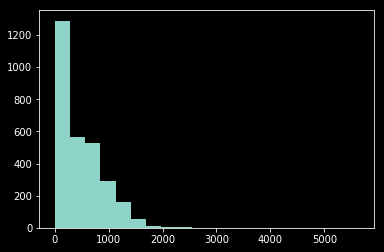

In [578]:
plt.hist(df['BsmtFinSF1'].dropna(),bins=20)#.plot(kind='hist')

In [579]:
df['BsmtFinSF1'].describe()

count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
25%         0.000000
50%       368.500000
75%       733.000000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

We will have to bin these out, perhaps into 4 or 5 buckets.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


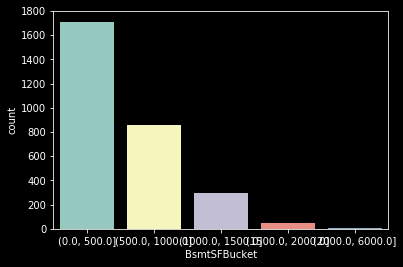

In [580]:
buckets = list(np.linspace(0, 2000, 5))
buckets.append(6000)
clean_df['BsmtSFBucket'] = pd.cut(clean_df['BsmtFinSF1'],buckets)
sns.countplot(clean_df['BsmtSFBucket'])

In [581]:
clean_df.drop(['BsmtFinSF1'],inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [582]:
clean_df['2ndFlrSF'] = clean_df['2ndFlrSF'] + 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([1.668e+03, 8.000e+00, 1.900e+01, 5.000e+01, 9.900e+01, 1.720e+02,
        2.090e+02, 1.990e+02, 2.100e+02, 7.300e+01, 7.000e+01, 5.200e+01,
        4.600e+01, 2.200e+01, 6.000e+00, 7.000e+00, 1.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00]),
 array([1.00000e+00, 1.04250e+02, 2.07500e+02, 3.10750e+02, 4.14000e+02,
        5.17250e+02, 6.20500e+02, 7.23750e+02, 8.27000e+02, 9.30250e+02,
        1.03350e+03, 1.13675e+03, 1.24000e+03, 1.34325e+03, 1.44650e+03,
        1.54975e+03, 1.65300e+03, 1.75625e+03, 1.85950e+03, 1.96275e+03,
        2.06600e+03]),
 <a list of 20 Patch objects>)

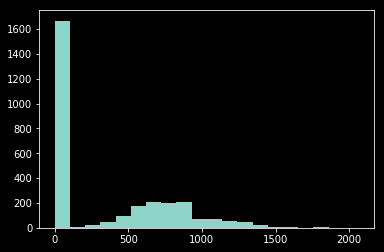

In [583]:
plt.hist(clean_df['2ndFlrSF'].dropna(),bins=20)#.plot(kind='hist')

Lets create a binary to indicate if this has a second floor or not. 

In [584]:
clean_df['2ndFlor'] = clean_df['2ndFlrSF'].apply(lambda x: has_feature(x))
clean_df.drop(['2ndFlrSF'],inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [585]:
clean_df['OpenPorchSF'] = clean_df['OpenPorchSF'] + 1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(array([1.298e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+01, 2.600e+01, 1.230e+02, 2.230e+02, 2.780e+02,
        2.600e+02, 2.320e+02, 2.100e+02, 1.400e+02, 8.300e+01, 2.400e+01,
        6.000e+00, 3.000e+00]),
 array([0.        , 0.14354944, 0.28709888, 0.43064832, 0.57419776,
        0.7177472 , 0.86129664, 1.00484608, 1.14839553, 1.29194497,
        1.43549441, 1.57904385, 1.72259329, 1.86614273, 2.00969217,
        2.15324161, 2.29679105, 2.44034049, 2.58388993, 2.72743937,
        2.87098881]),
 <a list of 20 Patch objects>)

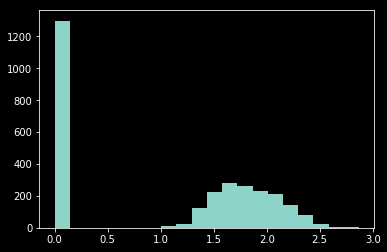

In [586]:
plt.hist(np.log10(clean_df['OpenPorchSF'].dropna()),bins=20)#.plot(kind='hist')

In [587]:
clean_df['OpenPorch'] = clean_df['OpenPorchSF'].apply(lambda x: has_feature(x))

(array([157.,   1.,  86., 353., 270., 413., 506., 476., 203., 137., 111.,
        115.,  50.,  14.,   9.,   7.,   4.,   1.,   3.,   2.]),
 array([1.0000e+00, 7.5400e+01, 1.4980e+02, 2.2420e+02, 2.9860e+02,
        3.7300e+02, 4.4740e+02, 5.2180e+02, 5.9620e+02, 6.7060e+02,
        7.4500e+02, 8.1940e+02, 8.9380e+02, 9.6820e+02, 1.0426e+03,
        1.1170e+03, 1.1914e+03, 1.2658e+03, 1.3402e+03, 1.4146e+03,
        1.4890e+03]),
 <a list of 20 Patch objects>)

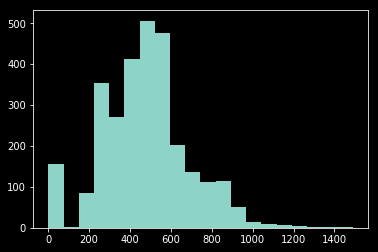

In [588]:
df['GarageArea'] = df['GarageArea'] + 1
plt.hist(df['GarageArea'].dropna(),bins=20)#.plot(kind='hist')

(array([  1.,   0.,   2.,   1.,   3.,   2.,  13.,  14.,  28.,  76., 186.,
        170., 256., 250., 287., 346., 350., 320., 212., 131., 108.,  87.,
         46.,  12.,   9.,   4.,   0.,   2.,   2.,   1.]),
 array([2.52374647, 2.56466935, 2.60559224, 2.64651513, 2.68743802,
        2.7283609 , 2.76928379, 2.81020668, 2.85112956, 2.89205245,
        2.93297534, 2.97389823, 3.01482111, 3.055744  , 3.09666689,
        3.13758977, 3.17851266, 3.21943555, 3.26035844, 3.30128132,
        3.34220421, 3.3831271 , 3.42404998, 3.46497287, 3.50589576,
        3.54681865, 3.58774153, 3.62866442, 3.66958731, 3.71051019,
        3.75143308]),
 <a list of 30 Patch objects>)

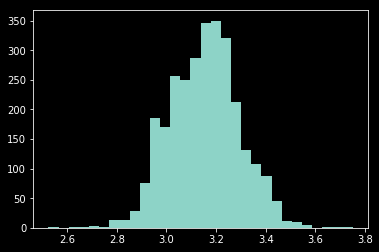

In [589]:
#df['GrLivArea'] = df['GrLivArea'] + 1
plt.hist(np.log10(df['GrLivArea'].dropna()),bins=30)#.plot(kind='hist')

In [590]:
needlog.append('GrLivArea')

In [606]:
areas

['Id',
 'LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'OpenPorchSF',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'GarageArea',
 'PoolArea',
 'GrLivArea',
 'SalePrice']

(array([1.523e+03, 0.000e+00, 1.000e+00, 4.000e+00, 3.200e+01, 8.200e+01,
        4.920e+02, 6.450e+02, 1.340e+02, 6.000e+00]),
 array([0.        , 0.31538149, 0.63076297, 0.94614446, 1.26152595,
        1.57690743, 1.89228892, 2.20767041, 2.52305189, 2.83843338,
        3.15381486]),
 <a list of 10 Patch objects>)

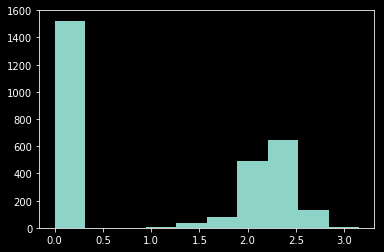

In [597]:
df['WoodDeckSF'] = df['WoodDeckSF'] + 1
plt.hist(np.log10(df['WoodDeckSF'].dropna()))

In [599]:
clean_df['WoodDeck'] = clean_df['WoodDeckSF'].apply(lambda x: has_feature(x))

(array([2.882e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 7.000e+00, 2.200e+01, 7.000e+00]),
 array([0.        , 0.27067178, 0.54134356, 0.81201533, 1.08268711,
        1.35335889, 1.62403067, 1.89470245, 2.16537423, 2.436046  ,
        2.70671778]),
 <a list of 10 Patch objects>)

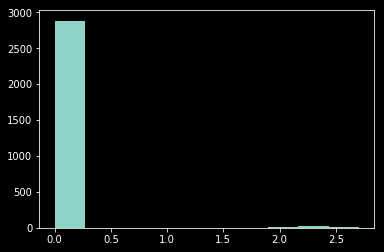

In [607]:
df['EnclosedPorch'] = df['EnclosedPorch'] + 1
plt.hist(np.log10(df['EnclosedPorch'].dropna()))

In [601]:
clean_df['HasEnclosedPorch'] = clean_df['EnclosedPorch'].apply(lambda x: has_feature(x))

(array([2.882e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.100e+01, 1.800e+01, 6.000e+00]),
 array([0.30103   , 0.54168401, 0.78233803, 1.02299205, 1.26364607,
        1.50430009, 1.7449541 , 1.98560812, 2.22626214, 2.46691616,
        2.70757018]),
 <a list of 10 Patch objects>)

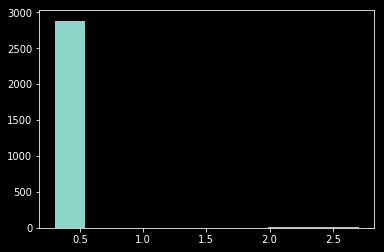

In [608]:
df['3SsnPorch'] = df['3SsnPorch'] + 1
plt.hist(np.log10(df['3SsnPorch'].dropna()))

In [610]:
clean_df['Has3SsnPorch'] = clean_df['3SsnPorch'].apply(lambda x: has_feature(x))

(array([2.663e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        6.000e+00, 1.010e+02, 1.350e+02, 1.300e+01]),
 array([0.        , 0.27611758, 0.55223516, 0.82835274, 1.10447033,
        1.38058791, 1.65670549, 1.93282307, 2.20894065, 2.48505823,
        2.76117581]),
 <a list of 10 Patch objects>)

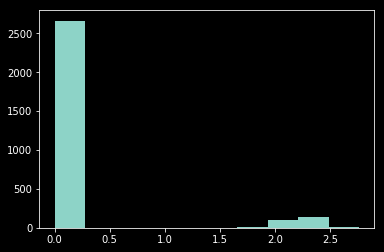

In [611]:
df['ScreenPorch'] = df['ScreenPorch'] + 1
plt.hist(np.log10(df['ScreenPorch'].dropna()))

In [613]:
clean_df['HasScreenPorch'] = clean_df['ScreenPorch'].apply(lambda x: has_feature(x))

## Feature Transformation

Steps:

1) create dummy variables from categorical features

2) scale and/or clean outliers in continous values

3) create features

Some features I think would be very informative would be some sort of bed to bathroom ratio, a feature that is the product of bathrooms (full + half as 0.5) and bedrooms. 

We could also create:
    - has second floor 
    - has pool and porch 
    
First, let's separate out the continous and the categorical columns. This is easy to determine by looking at the data dictionary. If a feature is not a continous, then it must be categorical. 

In [614]:
clean_df.columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BldgType',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'EnclosedPorch',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'FireplaceQu',
       'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageArea',
       'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Heating', 'HeatingQC',
       'HouseStyle', 'Id', 'KitchenAbvGr', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotArea', 'LotConfig', 'LotFrontage', 'LotShape',
       'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscVal', 'MoSold', 'Neighborhood', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'PavedDrive', 'PoolArea', 'RoofMatl', 'RoofStyle',
       'SaleCondit

In [615]:
areas = ['Id','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', 
         '2ndFlrSF', 'LowQualFinSF','OpenPorchSF', 'WoodDeckSF','OpenPorchSF',
         'EnclosedPorch','3SsnPorch','ScreenPorch',
         'GarageArea','PoolArea','GrLivArea','SalePrice']
cats = [e for e in clean_df.columns if e not in areas]
#cats.append('BsmtSFBucket')

### 1) Spanning out categorical variables

Let's first check if the categorical columns contain more than 2 values, if so, then they will spanned out.

In [616]:
need_dummies = [e for e in cats if len(clean_df[e].value_counts()) > 2]
binary_cols = [e for e in cats if len(clean_df[e].value_counts()) == 2]

In [617]:
len(need_dummies)

55

In [618]:
binary_cols

['CentralAir',
 'Street',
 'Utilities',
 'MasVnr',
 '2ndFlor',
 'OpenPorch',
 'WoodDeck',
 'HasEnclosedPorch',
 'Has3SsnPorch',
 'HasScreenPorch']

In [619]:
no_dummies = areas + binary_cols

In [620]:
final_df = clean_df[no_dummies]
#final_test = clean_test[no_dummies]

In [621]:
#getting dummy columns and taking k-1 columns

for cat in cats:
    temp = pd.get_dummies(clean_df[cat],prefix=cat,drop_first=True)
    final_df = pd.concat([final_df,temp],axis=1)
    temp = None

In [622]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 658 entries, Id to HasScreenPorch_1
dtypes: float64(8), int64(20), object(3), uint8(627)
memory usage: 2.5+ MB


### 2) Scaling continous features

As the areas aren't normally distributed and we do not want to throw out good data (even though it looks like an outlier), we will scale using a robust scaler.

The RobustScaler is cool in that it uses interquartile range instead of min-max, so it is robust to outliers. It takes the value, and subtracts it by the value of the 25% quartile, then divides it by the distance between the 75% and 25% quartiles:

    xi–Q1(x) / Q3(x)–Q1(x)


In [623]:
from sklearn.preprocessing import RobustScaler,StandardScaler

In [624]:
areas.pop(0)

'Id'

In [625]:
final_df['MasVnrArea'].describe()

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [626]:
final_df['MasVnrArea'] = final_df['MasVnrArea'].fillna(0)

In [627]:
scaler = RobustScaler()
scaled_vnr = scaler.fit_transform(final_df['MasVnrArea'].values.reshape(-1,1))

In [628]:
from sklearn.preprocessing import QuantileTransformer,MaxAbsScaler,MinMaxScaler,StandardScaler

In [629]:
#scaler = QuantileTransformer(output_distribution='uniform')
#scaler = MaxAbsScaler()
#scaler = MinMaxScaler()
scaler = RobustScaler()
#scaler = StandardScaler()
scaled_vnr = scaler.fit_transform(final_df['MasVnrArea'].values.reshape(-1,1))

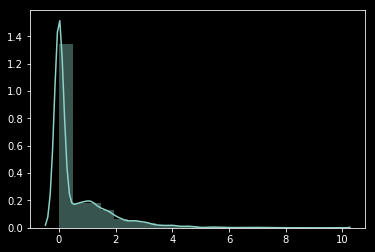

In [630]:
sns.distplot(scaled_vnr,bins=20)

In [631]:
final_df[areas].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 22 columns):
LotFrontage      2919 non-null float64
LotArea          2919 non-null int64
MasVnrArea       2919 non-null float64
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtUnfSF        2918 non-null float64
TotalBsmtSF      2918 non-null float64
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
LowQualFinSF     2919 non-null int64
OpenPorchSF      2919 non-null int64
OpenPorchSF      2919 non-null int64
WoodDeckSF       2919 non-null int64
OpenPorchSF      2919 non-null int64
OpenPorchSF      2919 non-null int64
EnclosedPorch    2919 non-null int64
3SsnPorch        2919 non-null int64
ScreenPorch      2919 non-null int64
GarageArea       2918 non-null float64
PoolArea         2919 non-null int64
GrLivArea        2919 non-null int64
SalePrice        1460 non-null float64
dtypes: float64(8), int64(14)
memory usage: 524.5 KB


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


7.105427357601002e-15

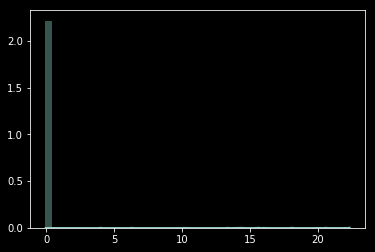

In [632]:
scaler =  StandardScaler()
poolScaled = scaler.fit_transform(final_df['PoolArea'].values.reshape(-1,1))
sns.distplot(poolScaled)
poolScaled.sum()

In [635]:
#final_df[areas] = final_df[areas].fillna(0)

In [636]:
#for area in areas:
#    scaler = RobustScaler()
#    final_df[area+'_scaled'] = scaler.fit_transform(final_df[area].values.reshape(-1,1))

In [637]:
final_df.columns

Index(['Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       ...
       'BsmtSFBucket_(2000.0, 6000.0]', '2ndFlor_1', 'OpenPorch_1',
       'WoodDeck_1', 'HasEnclosedPorch_1', 'Has3SsnPorch_1',
       'HasScreenPorch_1', 'LotFrontage_scaled', 'LotArea_scaled',
       'MasVnrArea_scaled'],
      dtype='object', length=661)

### log transformation and encoding the binary variables

In [638]:
for log in needlog:
    final_df[log+'_scaled'] = np.log10(final_df[log])

In [639]:
scaler = StandardScaler()

In [640]:
final_df['GarageArea'] = final_df['GarageArea'].fillna(0)
final_df['GarageArea_scaled'] = scaler.fit_transform(final_df['GarageArea'].values.reshape(-1,1))

In [641]:
binary_cols

['CentralAir',
 'Street',
 'Utilities',
 'MasVnr',
 '2ndFlor',
 'OpenPorch',
 'WoodDeck',
 'HasEnclosedPorch',
 'Has3SsnPorch',
 'HasScreenPorch']

In [647]:
final_df[binary_cols].head()

,CentralAir,Street,Utilities,MasVnr,2ndFlor,OpenPorch,WoodDeck,HasEnclosedPorch,Has3SsnPorch,HasScreenPorch
0,Y,Pave,AllPub,1,1,1,0,0,0,0
1,Y,Pave,AllPub,0,0,0,1,0,0,0
2,Y,Pave,AllPub,1,1,1,0,0,0,0
3,Y,Pave,AllPub,0,1,1,0,1,0,0
4,Y,Pave,AllPub,1,1,1,1,0,0,0


In [654]:
final_df['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [656]:
# binarizing the binary cols
from sklearn.preprocessing import Binarizer,OneHotEncoder,LabelEncoder

for col in binary_cols[0:2]:
    encoder = LabelEncoder()
    final_df[col] =  encoder.fit_transform(final_df[col].apply(int))

In [657]:
final_df['CentralAir'].value_counts()

1    2723
0     196
Name: CentralAir, dtype: int64

In [658]:
final_df.drop(['Utilities'],inplace=True)

In [1021]:
def outlier_flagger(series,limit=95):
    '''
    Function that takes in a series and flags each value for if it is a outlier, 
    returning a list you can insert into your pandas dataframe as a new columns.
    
    '''
    from numpy import median,percentile
    med = median(series)
    perc = percentile(series,limit)
    
    is_outlier = []
    
    for num in series:
        if num > perc:
            is_outlier.append(True)
        else:
            is_outlier.append(False)
    
    return is_outlier
    

### 3) Feature Creation

In [659]:
def has_pool(x):
    if x > 0:
        return 1
    else:
        return 0

In [660]:
final_df['lowQA'] = final_df['LowQualFinSF'].apply(lambda x: has_pool(x))

In [661]:
final_df['Pool'] = final_df['PoolArea'].apply(lambda x: has_pool(x))

In [662]:
from sklearn.preprocessing import Normalizer

#scaler = Normalizer()
#final_df['BsmtFinSF2_scaled'] = scaler.fit_transform(final_df['BsmtFinSF2'].values.reshape(-1,1))
#sns.distplot(final_df['BsmtFinSF2_scaled'])

In [663]:
df['BsmtFinType2'].value_counts()

Unf     2493
Rec      105
LwQ       87
None      80
BLQ       68
ALQ       52
GLQ       34
Name: BsmtFinType2, dtype: int64

In [664]:
final_df[final_df['BsmtFinSF2'] > 0]['Id'].count()

347

In [665]:
bad_areas = ['PoolArea_scaled','LowQualFinSF_scaled']

In [667]:
areas.remove("SalePrice")

In [674]:
scaled_df = final_df.drop(areas,axis=1)

In [675]:
scaled_df.columns[-3]

'GarageArea_scaled'

In [676]:
scaled_df['total_baths'] = clean_df['FullBath'] + (clean_df['HalfBath'] * 0.5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [959]:
#clean_df['total_bedrooms']  

In [960]:
#scaled_df['total_baths'] = scaled_df

In [677]:
scaled_df.columns

Index(['Id', 'SalePrice', 'CentralAir', 'Street', 'Utilities', 'MasVnr',
       '2ndFlor', 'OpenPorch', 'WoodDeck', 'HasEnclosedPorch',
       ...
       'Has3SsnPorch_1', 'HasScreenPorch_1', 'LotFrontage_scaled',
       'LotArea_scaled', 'MasVnrArea_scaled', 'GrLivArea_scaled',
       'GarageArea_scaled', 'lowQA', 'Pool', 'total_baths'],
      dtype='object', length=647)

In [678]:
sums = scaled_df.sum()
#sums[sums == 1]

## Modeling

In [1057]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_selection import SelectPercentile,SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso,LinearRegression,BayesianRidge
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor

In [1058]:
scaled_df.drop(['Utilities'],inplace=True)
train, test = scaled_df[scaled_df['Id']<1461], scaled_df[scaled_df['Id']> 1460]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1059]:
g = train.columns.to_series().groupby(train.dtypes).groups
g

{dtype('uint8'): Index(['BedroomAbvGr_1', 'BedroomAbvGr_2', 'BedroomAbvGr_3', 'BedroomAbvGr_4',
        'BedroomAbvGr_5', 'BedroomAbvGr_6', 'BedroomAbvGr_8', 'BldgType_2fmCon',
        'BldgType_Duplex', 'BldgType_Twnhs',
        ...
        'BsmtSFBucket_(500.0, 1000.0]', 'BsmtSFBucket_(1000.0, 1500.0]',
        'BsmtSFBucket_(1500.0, 2000.0]', 'BsmtSFBucket_(2000.0, 6000.0]',
        '2ndFlor_1', 'OpenPorch_1', 'WoodDeck_1', 'HasEnclosedPorch_1',
        'Has3SsnPorch_1', 'HasScreenPorch_1'],
       dtype='object', length=627),
 dtype('int64'): Index(['Id', 'CentralAir', 'Street', 'MasVnr', '2ndFlor', 'OpenPorch',
        'WoodDeck', 'HasEnclosedPorch', 'Has3SsnPorch', 'HasScreenPorch',
        'lowQA', 'Pool'],
       dtype='object'),
 dtype('float64'): Index(['SalePrice', 'LotFrontage_scaled', 'LotArea_scaled',
        'MasVnrArea_scaled', 'GrLivArea_scaled', 'GarageArea_scaled',
        'total_baths'],
       dtype='object'),
 dtype('O'): Index(['Utilities'], dtype='object')}

In [1265]:
x = train.drop(['Id','SalePrice','Utilities'],axis=1)
x_validate = test.drop(['Id','SalePrice','Utilities'],axis=1)
x_sums = x.sum()

In [1266]:
x_sums[1]

1454.0

## Feature Selection

In [1267]:
sumDf = pd.DataFrame()
sumDf['feature'] = x.columns
sumDf['sum'] = x_sums.values
sumDf.head()

,feature,sum
0,CentralAir,1365.0
1,Street,1454.0
2,MasVnr,589.0
3,2ndFlor,631.0
4,OpenPorch,804.0


In [1268]:
x_sums[(x_sums != 1) |(x_sums != 0)].head()

CentralAir    1365.0
Street        1454.0
MasVnr         589.0
2ndFlor        631.0
OpenPorch      804.0
dtype: float64

In [1269]:
len(x.columns)

644

In [1270]:
remove_cols = [col for col, val in x.sum().iteritems() if val < 2]
remove_cols.remove("GarageArea_scaled")

In [1271]:
x.drop(remove_cols, axis=1, inplace=True)

In [1272]:
len(x.columns)

563

In [1273]:
#np.seterr(divide='ignore', invalid='ignore')
#kbest = SelectPercentile(percentile=5)
kbest = SelectKBest(k=250)
x_fit = kbest.fit(x,y)

In [1274]:
mask = kbest.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, x.columns):
    if bool:
        new_features.append(feature)

In [1275]:
new_features[0:5]

['CentralAir', 'Street', 'MasVnr', '2ndFlor', 'OpenPorch']

In [1276]:
#scaled_df['SalePrice'] = df['SalePrice']
#x = scaled_df.drop(['Id','SalePrice','SalePrice_scaled'],axis=1)
x = x[new_features]
y = train['SalePrice']

### Cross Validation

In [1277]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=42)

### Lasso

In [1278]:
lasso = Lasso(tol=0.1)

In [1279]:
lasso.fit(x_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.1, warm_start=False)

In [1280]:
lasso.coef_[0:5]

array([66834.18272937, 17887.75937442, 43648.28936923, 15477.83460172,
       40332.6850868 ])

In [1281]:
lasso_pred = lasso.predict(x_test)

In [1282]:
lasso.score(x_test,y_test)

0.7965708720931778

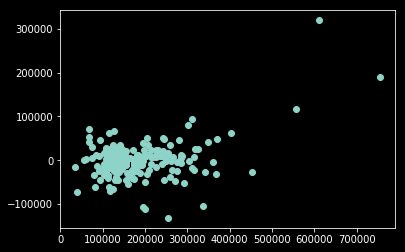

In [1283]:
lasso_error = y_test - lasso_pred
plt.scatter(y_test,lasso_error)

In [1284]:
lasso_error.describe()

count       219.000000
mean       1428.470067
std       40707.235228
min     -131744.893834
25%      -16527.428641
50%         832.748084
75%       17161.005511
max      319646.661965
Name: SalePrice, dtype: float64

In [1285]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

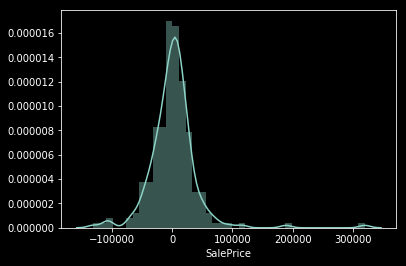

In [1286]:
sns.distplot(lasso_error)

In [1287]:
lasso_mse = mean_squared_error(y_pred=lasso_pred,y_true=y_test)
lasso_mse

1651552955.8537643

In [1288]:
lass_coef = pd.DataFrame()

lass_coef['features'] = x.columns
lass_coef['scores'] = lasso.coef_
lass_coef['sums'] = x_sums

In [1289]:
lass_coef.sort_values(['scores'],ascending=False).head()

,features,scores,sums
170,OverallQual_10,94550.110682,NaN
247,GrLivArea_scaled,83109.523752,NaN
0,CentralAir,66834.182729,NaN
109,GarageYrBlt_2009.0,58610.388118,NaN
45,Exterior2nd_ImStucc,55894.898477,NaN


In [1290]:
#lass_coef[(lass_coef['scores'] < 1000) & (lass_coef['scores'] > -1000)]

### Feature Importances from remaining features using Random Forest

In [1291]:
RF = RandomForestRegressor(min_samples_split=15,n_estimators=500,max_features=50)
RF.fit(x_train,y_train)
RF.score(x_test,y_test)

0.8224625349806376

In [1292]:
RF.score(x_train,y_train)

0.9232534398285845

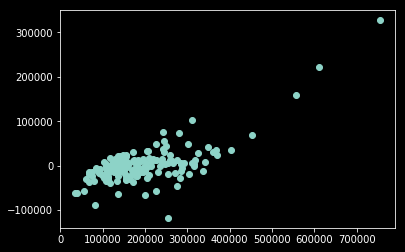

In [1293]:
rf_pred = RF.predict(x_test)
rf_error = y_test - rf_pred
plt.scatter(y_test,rf_error)

In [1294]:
rf_error.describe()

count       219.000000
mean        990.921765
std       38039.124965
min     -117700.886789
25%      -13919.291836
50%       -1327.107427
75%        9559.118413
max      327293.452906
Name: SalePrice, dtype: float64

In [1295]:
rf_mse = mean_squared_error(y_pred=rf_pred,y_true=y_test)
rf_mse

1441349762.1727705

In [1296]:
imp = pd.DataFrame()
imp['Features'] = x.columns
imp['Importance'] = RF.feature_importances_
imp.sort_values(['Importance'],ascending=False).head(10)

,Features,Importance
247,GrLivArea_scaled,0.164376
63,GarageCars_3.0,0.127486
248,GarageArea_scaled,0.086956
39,ExterQual_TA,0.076544
249,total_baths,0.052566
57,FullBath_1,0.039854
245,LotArea_scaled,0.033467
121,KitchenQual_TA,0.029421
49,FireplaceQu_None,0.023378
54,Foundation_PConc,0.022317


In [1174]:
len(imp[imp['Importance']>0.001])

68

In [1175]:
final_feats = list(imp[imp['Importance']>0.001]['Features'])

In [1176]:
x = train[final_feats]
x_validate = test[final_feats]

In [1177]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.15,random_state=42)

### AdaBoost Regressor

In [1297]:
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor,GradientBoostingRegressor

In [1319]:
#gdr = AdaBoostRegressor()
gdr = GradientBoostingRegressor()#min_samples_split=5,learning_rate=0.5)
gdr.fit(x_train,y_train)
gdr.score(x_test,y_test)

0.8544081136619049

In [1320]:
gdr.score(x_train,y_train)

0.9483246572042542

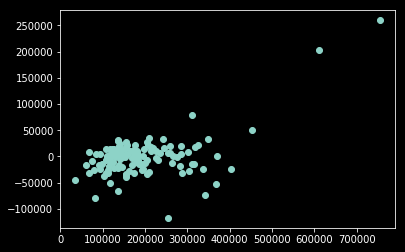

In [1321]:
ada_pred = gdr.predict(x_test)
ada_error = y_test - ada_pred
plt.scatter(y_test,ada_error)

In [1322]:
ada_error.describe()

count       146.000000
mean        235.952172
std       36596.973942
min     -117295.122769
25%      -15295.469666
50%        1153.451266
75%       12126.221825
max      259860.470481
Name: SalePrice, dtype: float64

In [1323]:
ada_mse = mean_squared_error(y_pred=ada_pred,y_true=y_test)
ada_mse

1330220623.7675161

In [1324]:
ada_mse > lasso_mse

False

Gradient Boost is the winner so far...

### Bayesian Ridge

In [1304]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.1,random_state=42)

In [1305]:
#reg = RandomForestRegressor()
reg = BayesianRidge()
reg.fit(x_train,y_train)
reg.score(x_test,y_test)

0.8533797682544224

In [1306]:
#reg.feature_importances_

In [1307]:
#reg.predict(x_test.iloc[56].values.reshape(1,-1))
br_preds = reg.predict(x_test)

In [1308]:
reg.predict(x_test.iloc[90].values.reshape(1,-1))

array([135295.17992158])

In [1309]:
y_test.iloc[90]

153500.0

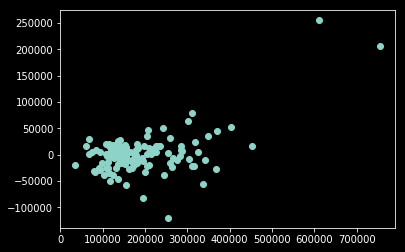

In [1310]:
br_error = y_test - br_preds
plt.scatter(y_test,br_error)

In [1311]:
br_error.describe()

count       146.000000
mean       2262.515168
std       36656.523293
min     -120005.899712
25%      -11953.705710
50%        1882.835869
75%       12129.614123
max      255478.276336
Name: SalePrice, dtype: float64

In [1312]:
lasso_error.describe()

count       219.000000
mean       1428.470067
std       40707.235228
min     -131744.893834
25%      -16527.428641
50%         832.748084
75%       17161.005511
max      319646.661965
Name: SalePrice, dtype: float64

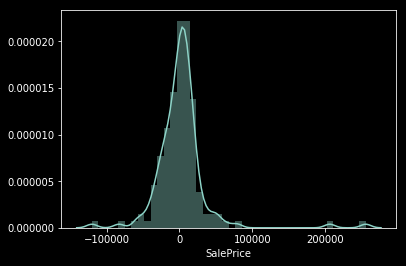

In [1313]:
sns.distplot(br_error)

In [1314]:
reg.score(x_train,y_train)

0.904806235983691

In [1315]:
reg.score(x_test,y_test)

0.8533797682544224

In [1316]:
f_importances = pd.DataFrame(columns=['features','scores'])
f_importances['features'] = x.columns
f_importances['scores'] = reg.coef_
f_importances.sort_values('scores',ascending=False).head(4)

,features,scores
247,GrLivArea_scaled,75624.106994
170,OverallQual_10,64229.055444
169,OverallQual_9,48463.332508
239,"BsmtSFBucket_(1500.0, 2000.0]",38518.997207


In [1317]:
br_mse = mean_squared_error(y_pred=br_preds,y_true=y_test)
br_mse

1339616245.349156

In [1325]:
ada_mse

1330220623.7675161

In [1326]:
br_mse > ada_mse

True

In [777]:
#weak_f =  list(f_importances[(f_importances['scores'] <= 100 ) &
#              (f_importances['scores'] >= -100)]['features'])

In [297]:
#x = x.drop(weak_f,axis=1)

In [298]:
#final_cols = x.columns

In [1327]:
winning = gdr

# Get predictions

In [1330]:
final_feats = x.columns

In [1331]:
x_validate_final = x_validate[final_feats]


valid_pred = winning.predict(x_validate_final)

In [1332]:
final_pred = pd.DataFrame()
final_pred['Id'] = test['Id']
final_pred['SalePrice'] = valid_pred
final_pred.set_index(['Id'],inplace=True)

In [1333]:
final_pred.to_csv("housing_preds_br_2.csv")